In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
from sklearn.externals import joblib
from skimage import io, color, img_as_bool, exposure, transform, feature
import my_measures # note, this was updated March 27; make sure you are using the current version! 
%matplotlib inline

In [2]:
# file paths/names

root_dir = '/Users/juandherrera'

ci_path = root_dir + '/Google Drive/017_Machine Learning/ml_largefiles/plane_data/cropped_images_18/' # cropped images for training
l_file = root_dir + '/Google Drive/017_Machine Learning/ml_largefiles/plane_data/plane_labels_2018.csv' # csv with labels

# get labels and extract features from images

In [3]:
# all labels
plane_data = pd.read_csv(l_file)
print(plane_data.head())
print(plane_data.shape)

                   img_name  plane
0  2016-08-02T13+50+24_430Z  False
1  2016-08-02T14+12+37_390Z  False
2  2016-08-02T22+20+26_600Z  False
3  2016-08-03T12+04+30_670Z  False
4  2016-08-03T12+32+21_790Z  False
(6758, 2)


In [4]:
# in downscaling the image, what do you want the new dimensions to be?
# the original dimensions of cropped images: (60, 140), which if 8,400 pixels
# dims = (30, 70) # 50% of the original size, 2100 pixels
dims = (15, 35) # 25% of the original size, 525 pixels

downscaled image shape: 
(15, 35)
image representation (first row of pixels): 
[0.16773617 0.13796129 0.20118674 0.28852054 0.24794293 0.13268957
 0.15173965 0.14126779 0.10721616 0.09421535 0.13566051 0.21551612
 0.20376117 0.31565683 0.21267712 0.22751055 0.22745309 0.33052681
 0.24417751 0.20743828 0.26973534 0.19175703 0.09360836 0.10931477
 0.1282102  0.08070107 0.11197528 0.16024528 0.19339627 0.23068293
 0.31089151 0.04468783 0.20266799 0.2118496  0.18867183]


example of transformation: 


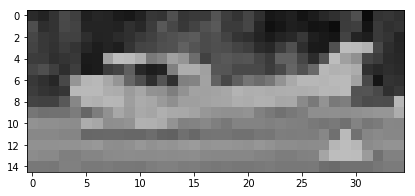

In [5]:
# scikit-image documentation on methods used for feature extraction: 
#    http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray
#    http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize
#    http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

def image_manipulation(imname, imview=False):
    warnings.filterwarnings('ignore')
    imname = ci_path + imname + '.png'
    img_raw = io.imread(imname)
    hist = exposure.equalize_hist(img_raw)
#   downscaled = transform.resize(hist, (dims[0], dims[1]))
    gray = color.rgb2gray(hist) # remove color
    
#     boolimg = img_as_bool(gray)
    downscaled = transform.resize(gray, (dims[0], dims[1])) # downscale image
    final_image = downscaled # edge filter image with Canny algorithm
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# test the function, look at input/output
test_image = image_manipulation('2017-08-25T23+24+13_390Z', True)
print('downscaled image shape: ')
print(test_image.shape)
print('image representation (first row of pixels): ')
print(test_image[0])
print('\n')
print('example of transformation: ')

In [6]:
# construct lists for features, labels, and a crosswalk reference to image names

features_list = []
y_list = []
imnames_list = []

for index, row in plane_data.iterrows():
    features_list.append(image_manipulation(row['img_name']))
    y_list.append(row['plane'])
    imnames_list.append(row['img_name'])
    

In [7]:
# convert the lists to ndarrays
features = np.asarray(features_list)
Y = np.asarray(y_list)
imgs = np.asarray(imnames_list)
print('Shape of original feature representation: ')
print(features.shape)

# flatten the images ndarray to one row per image
features_flat = features.reshape((features.shape[0], -1))

print('Shape of flat feature representation: ')
print(features_flat.shape)

print('Shape of Y: ')
print(Y.shape)

print('Number of images with planes: ')
print(Y.sum())

Shape of original feature representation: 
(6758, 15, 35)
Shape of flat feature representation: 
(6758, 525)
Shape of Y: 
(6758,)
Number of images with planes: 
101


In [8]:
# create train and test sets
from sklearn.model_selection import train_test_split

# enter an integer for random_state
data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
    Y, imgs, test_size = 0.25, random_state = 32)

print('Shape of training set: ')
print(y_train.shape)
print('Number of training images that contain an airplane: ')
print(y_train.sum())

print(' ')

print('Shape of test set: ')
print(y_test.shape)
print('Number of test images that contain an airplane: ')
print(y_test.sum())

Shape of training set: 
(5068,)
Number of training images that contain an airplane: 
68
 
Shape of test set: 
(1690,)
Number of test images that contain an airplane: 
33


# train Perceptron

In [32]:
# MODEL: Perceptron
from sklearn import linear_model
prc = linear_model.SGDClassifier(max_iter=500, loss='perceptron', class_weight="balanced")
prc.fit(data_train, y_train)
joblib.dump(prc, 'prc.pkl')

prc_performance = my_measures.BinaryClassificationPerformance(prc.predict(data_train), y_train, 'prc')
prc_performance.compute_measures()
prc_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(prc_performance.performance_measures)

prc_performance_test = my_measures.BinaryClassificationPerformance(prc.predict(data_test), y_test, 'prc')
prc_performance_test.compute_measures()
prc_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(prc_performance_test.performance_measures)

prc_performance_test.img_indices()
prc_img_indices_to_view = prc_performance_test.image_indices

/Users/juandherrera/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


TRAINING SET: 
{'Pos': 68, 'Neg': 5000, 'TP': 68, 'TN': 4897, 'FP': 103, 'FN': 0, 'Accuracy': 0.9796764009471192, 'Precision': 0.39766081871345027, 'Recall': 1.0, 'desc': 'prc', 'set': 'train'}
TEST SET: 
{'Pos': 33, 'Neg': 1657, 'TP': 18, 'TN': 1622, 'FP': 35, 'FN': 15, 'Accuracy': 0.9704142011834319, 'Precision': 0.33962264150943394, 'Recall': 0.5454545454545454, 'desc': 'prc', 'set': 'test'}


In [33]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
#         print(imnames_list[img])
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(dims[0], dims[1])) # show manipulation for feature representation
        warnings.filterwarnings('always')


# look at examples of Perceptron classifications

## true positives

In [34]:
# performance_examples('TP', prc_img_indices_to_view)

## false positives

In [35]:
# performance_examples('FP', prc_img_indices_to_view)

## false negatives

In [36]:
# performance_examples('FN', prc_img_indices_to_view)

# train Multilayer Perceptron, a.k.a. neural network

In [37]:
# MODEL: Multi-layer Perceptron aka neural network
from sklearn import neural_network
nn = neural_network.MLPClassifier(hidden_layer_sizes=(3,3), alpha=0.0001, max_iter=1000)
# print(nn)
nn.fit(data_train, y_train)
joblib.dump(nn, 'nn.pkl')

nn_performance = my_measures.BinaryClassificationPerformance(nn.predict(data_train), y_train, 'nn')
nn_performance.compute_measures()
nn_performance.performance_measures['set'] = 'train'
print('TRAINING SET: ')
print(nn_performance.performance_measures)

nn_performance_test = my_measures.BinaryClassificationPerformance(nn.predict(data_test), y_test, 'nn_test')
nn_performance_test.compute_measures()
nn_performance_test.performance_measures['set'] = 'test'
print('TEST SET: ')
print(nn_performance_test.performance_measures)

nn_performance_test.img_indices()
nn_img_indices_to_view = nn_performance_test.image_indices

TRAINING SET: 
{'Pos': 68, 'Neg': 5000, 'TP': 68, 'TN': 5000, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn', 'set': 'train'}
TEST SET: 
{'Pos': 33, 'Neg': 1657, 'TP': 17, 'TN': 1655, 'FP': 2, 'FN': 16, 'Accuracy': 0.9893491124260355, 'Precision': 0.8947368421052632, 'Recall': 0.5151515151515151, 'desc': 'nn_test', 'set': 'test'}


# look at examples of neural network classifications

## true positives

In [38]:
# performance_examples('TP', nn_img_indices_to_view)

## false positives

In [39]:
# performance_examples('FP', nn_img_indices_to_view)

## false negatives

In [40]:
# performance_examples('FN', nn_img_indices_to_view)

# comparisons

In [41]:
# list of fits to compare: 
final_fits = []
final_fits.append(prc_performance.performance_measures)
final_fits.append(prc_performance_test.performance_measures)
final_fits.append(nn_performance.performance_measures)
final_fits.append(nn_performance_test.performance_measures)

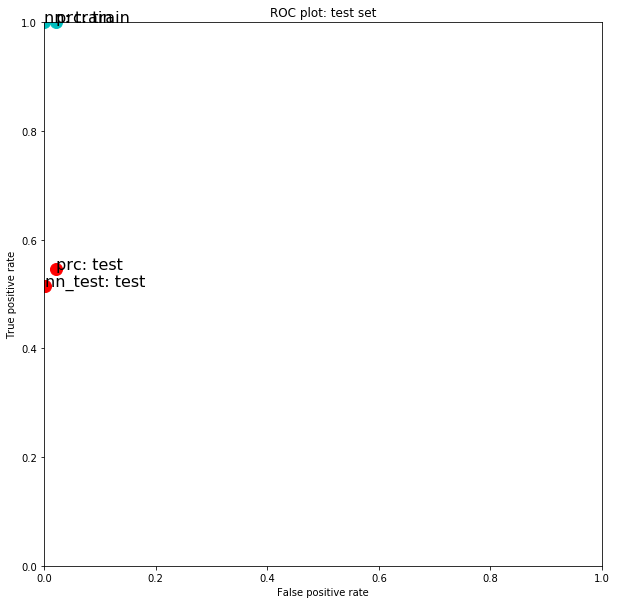

In [42]:
plt.figure(figsize=(10,10))

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()
